In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout
plt.rcParams['font.size']=14
img_size = 224


In [ ]:
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1/255.,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            validation_split=0.15)


train_generator = datagen.flow_from_directory('/content/drive/MyDrive/animal10_dataset/raw-img',
                                              target_size=(img_size,img_size),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              subset='training',
                                              #color_mode='grayscale',
                                              class_mode='categorical')


Found 22257 images belonging to 10 classes.


In [ ]:
val_generator = datagen.flow_from_directory('/content/drive/MyDrive/animal10_dataset/raw-img',
                                            target_size=(img_size,img_size),
                                            batch_size=batch_size,
                                            shuffle=False,
                                            subset='validation',
                                            #color_mode='grayscale',
                                            class_mode='categorical')

Found 3922 images belonging to 10 classes.


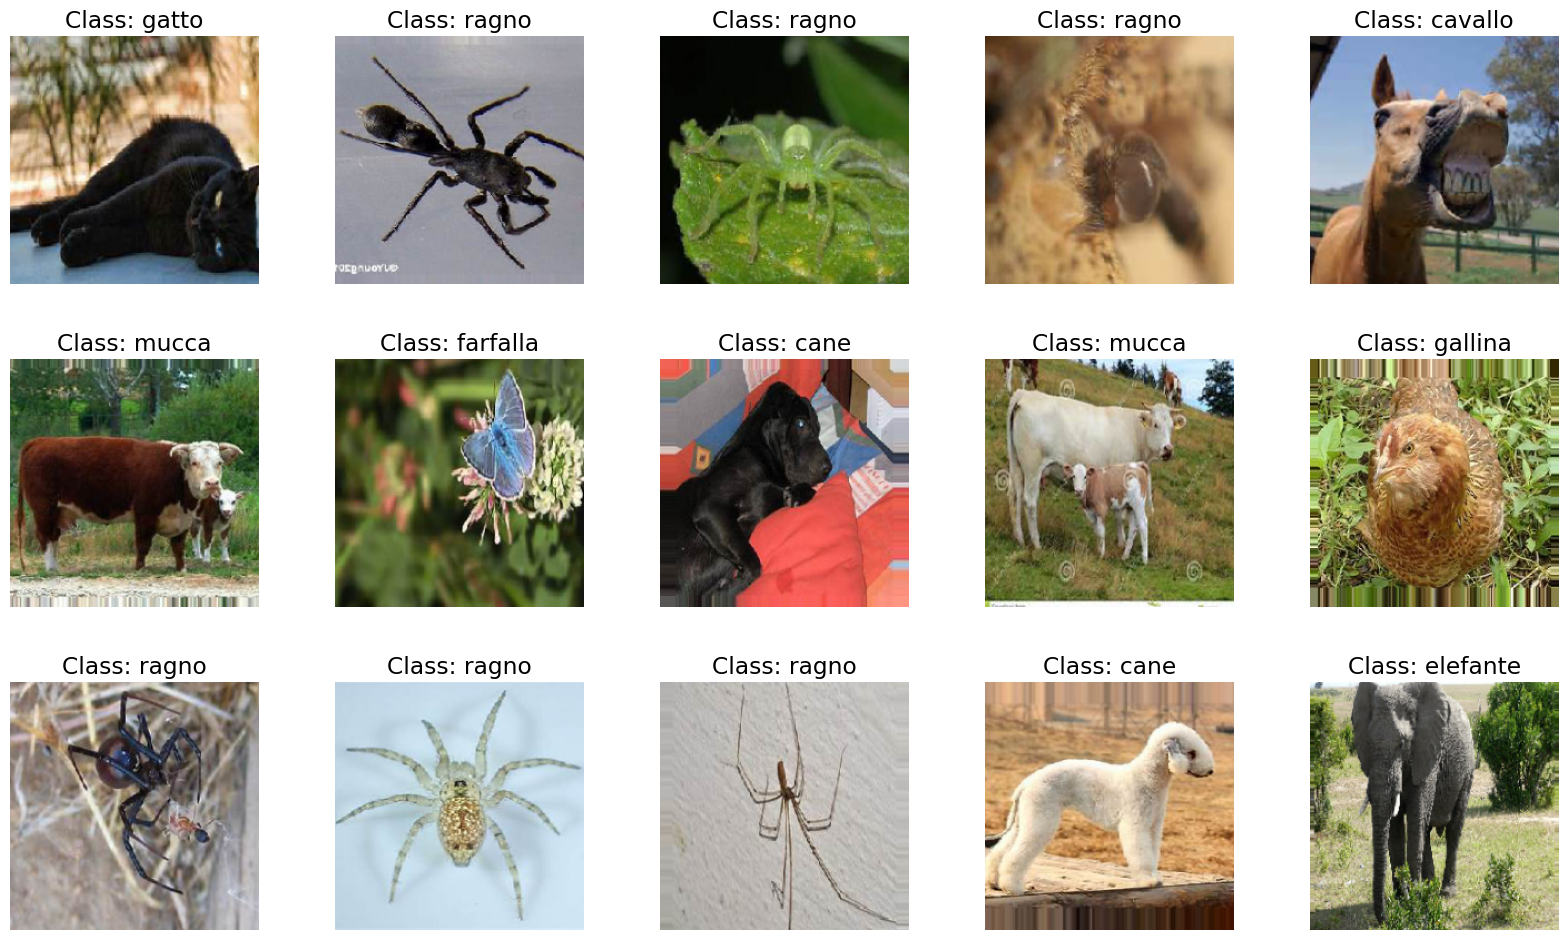

In [ ]:
label = [k for k in train_generator.class_indices]
samples = train_generator.__next__()
images = samples[0]
titles = samples[1]
plt.figure(figsize=(20,20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {label[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")

In [ ]:
base_model=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
len(base_model.layers)

19

In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model_name = "model99.h5"
Checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only = True, verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator,epochs=5,validation_data=val_generator,callbacks=[Checkpoint,es])

Epoch 1/5
696/696 [==============================] - ETA: 0s - loss: 0.8084 - accuracy: 0.7328
Epoch 1: val_loss improved from inf to 0.39882, saving model to model.h5
696/696 [==============================] - 347s 489ms/step - loss: 0.8084 - accuracy: 0.7328 - val_loss: 0.3988 - val_accuracy: 0.8725
Epoch 2/5
696/696 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.8782
Epoch 2: val_loss improved from 0.39882 to 0.30306, saving model to model.h5
696/696 [==============================] - 329s 473ms/step - loss: 0.3828 - accuracy: 0.8782 - val_loss: 0.3031 - val_accuracy: 0.8988
Epoch 3/5
696/696 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9092
Epoch 3: val_loss improved from 0.30306 to 0.28913, saving model to model.h5
696/696 [==============================] - 330s 474ms/step - loss: 0.2854 - accuracy: 0.9092 - val_loss: 0.2891 - val_accuracy: 0.9108
Epoch 4/5
696/696 [==============================] - ETA: 0s - loss: 0.2262 - accur

In [ ]:
model = tf.keras.models.load_model("model.h5")

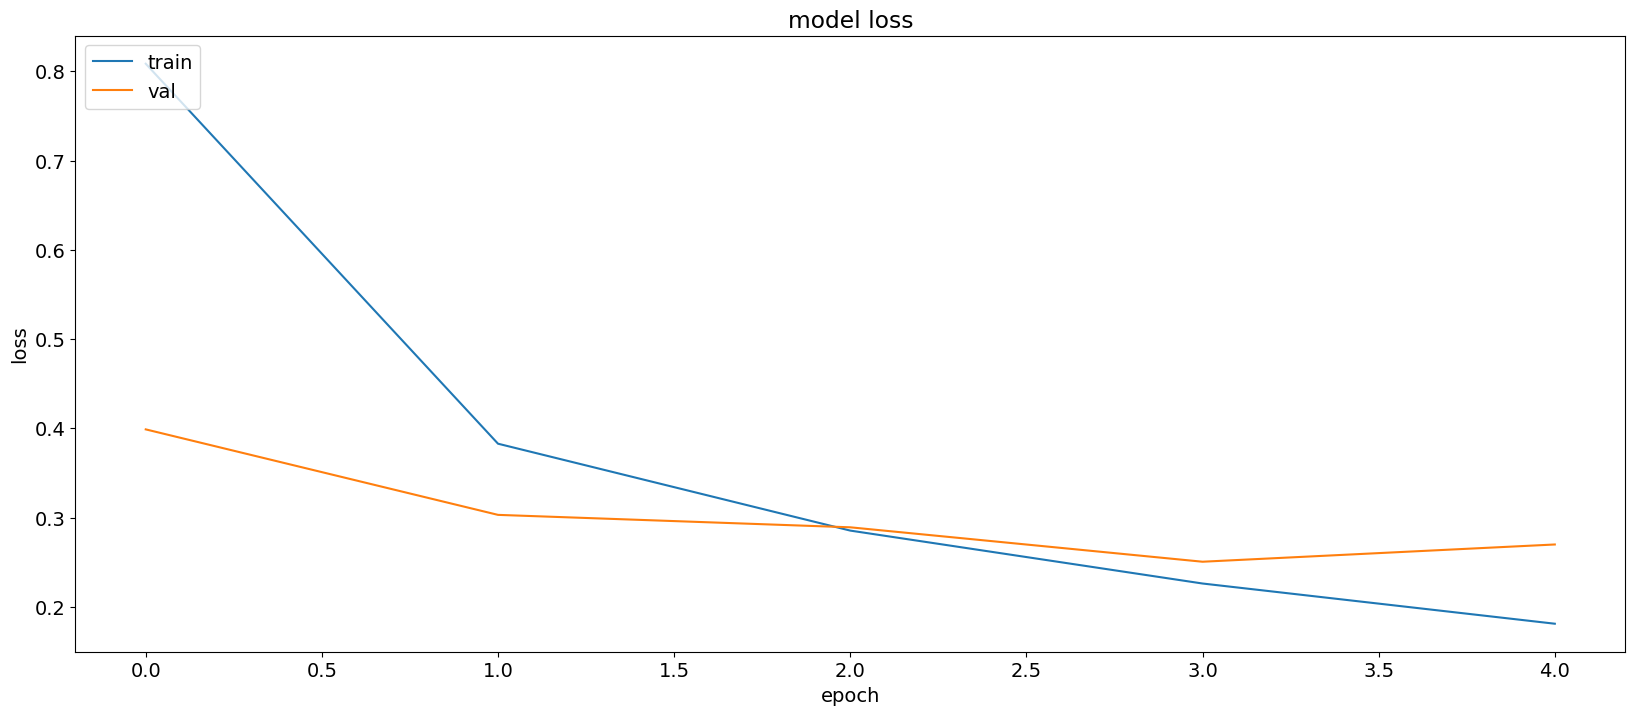

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

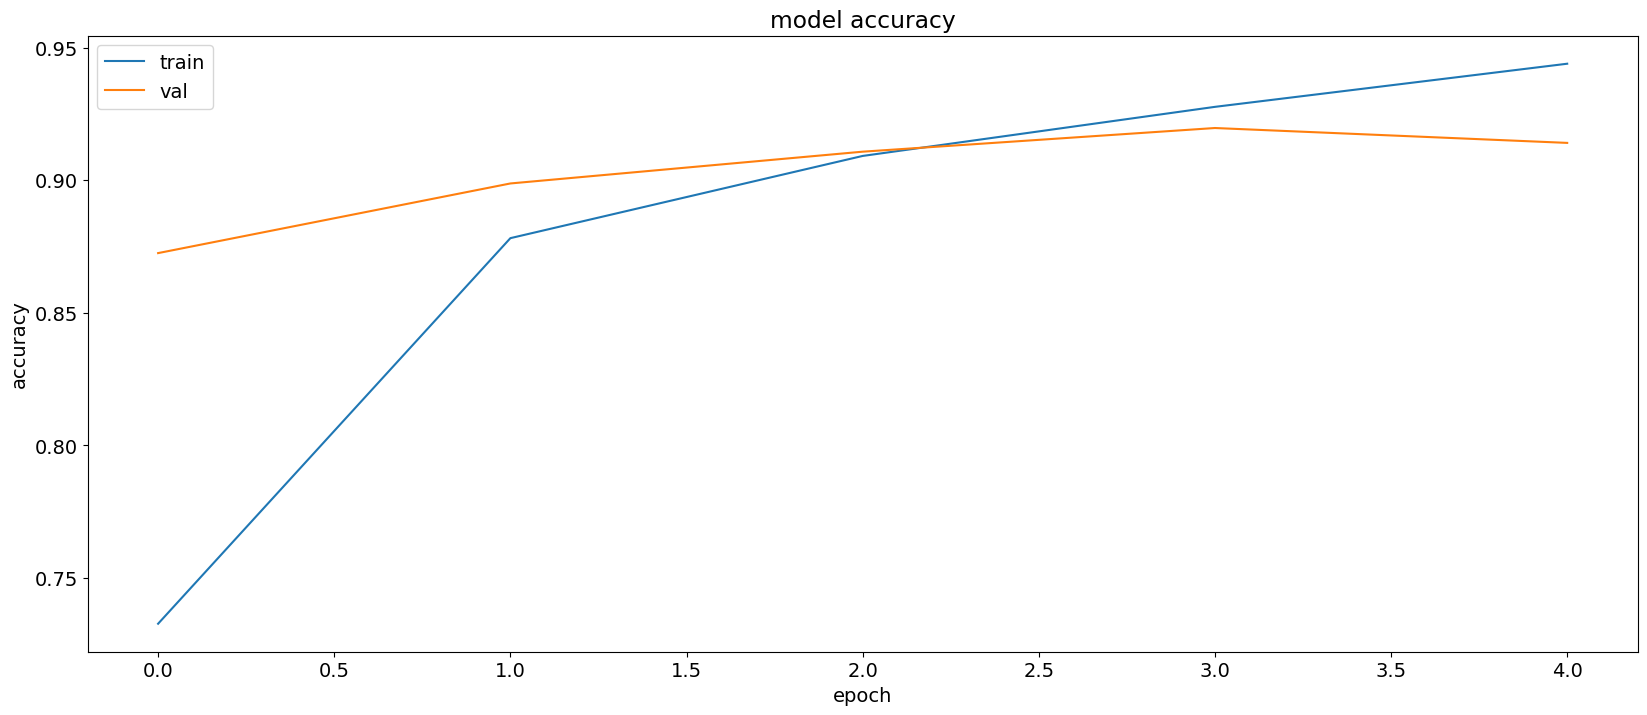

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

123/123 [==============================] - 45s 366ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

              precision    recall  f1-score   support

        cane       0.94      0.89      0.91       729
     cavallo       0.94      0.88      0.91       393
    elefante       0.89      0.95      0.92       216
    farfalla       0.93      0.94      0.94       316
     gallina       0.97      0.94      0.95       464
       gatto       0.81      0.94      0.87       250
       mucca       0.86      0.87      0.87       279
      pecora       0.84      0.86      0.85       273
       ragno       0.95      0.99      0.97       723
  scoiattolo       0.93      0.86      0.89       279

    accuracy                           0.92      3922
   macro avg       0.91      0.91      0.91      3922
weighted avg       0.92      0.92      0.92      3922



RESNET50